# Comparison of runtime logs for deterministic estimators

The training of the deterministic estimator with four different settings will be examined here. The network is composed of two components, the **hider** and the **seeker**. Thus there are four possible ways of training the model:

1. **Vanilla (Full) training**: completely train the model from scratch.
2. **Pretrain hider**: pretrain the hider component of the network, in an unsupervised fashion, like an autoencoder.
3. **Pretrain seeker**: pretrain the seeker component of the network for classification.
4. **Pretrain both hider and seeker components**: combine 2 and 3 to pretrain both the network's components.

To properly measure the **variance** from one training to another (e.g. *how many times does the model actually converge?*), we **repeat the training of each model 10 times**.

Runtime logs are meant to study a model's **convergence**, i.e. *how many epochs does it take for a model to converge?*, *does it experience heavy oscillations during training?*, etc. They **aren't** meant to examine the model's generalization. There are two types of runtime logs:

- **epoch** logs are the ones that are recorded **once per epoch** (usually at the end of the epoch), e.g. validation metrics.
- **batch** logs are the ones that are recorded **once per batch** (i.e. once per model update), e.g. the model's loss.

While it is possible to examine the logs in other ways, the scope of this study involves examining the **least** amount of information that the models require to **adequately** classify. Thus we'll follow the following procedure:

1. For each model that we want to examine, first we'll check its **validation accuracy**. Only models with sufficiently high validation accuracy, comared to the baseline, will be examined further.
2. They we'll check the model's **percentage of pixels hidden**. As we said we are interested in finding the least amount of information that the models require, so we'll keep the models that hide large percentage of pixels.
3. After filtering the models by these two conditions, we'll examine things such as the convergence speed and the stability of the model.

**Note 1**: All helper functions are defined in `../utils/plotting.py`.
**Note 2**: Due to early stopping, some models trained for longer than others. In order to plot them in the same graph, the models that finished earlier were extended to the max number of epochs (or iterations). This is why they'll appear flat  in the graphs.

In [1]:
import sys
sys.path.append('..')

from utils.plotting import *

%matplotlib inline

## 1. Epoch logs

Well first read the epoch logs to find the models that performed adequately on the validation set. 

### Load the baseline 

This baseline is the validation accuracy achieved by the same architecture that is used for the **seeker** on the test set, without hiding any pixels.

In [2]:
baseline_loc = '../results/cifar10/seeker/default/baseline.txt'
with open(baseline_loc) as f:
    baseline = float(f.read())
print('Baseline accuracy: {:.2f}%'.format(baseline * 100))

Baseline accuracy: 65.37%


### a) Full training

This involves the training of a model **completely from scratch** 10 times. The multiple trainings are intended to add a robustness to the experiments (e.g. a model might collapse during training).

In [3]:
experiment_dir = '../logs/cifar10/hns/deterministic/full_training_10/'
full_training_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)

W0823 15:09:12.281350 140111050487552 deprecation.py:323] From /home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/summary/summary_iterator.py:68: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Let's plot the runtime validation accuracy of all 10 models.

Text(0.5, 1.0, 'Full training')

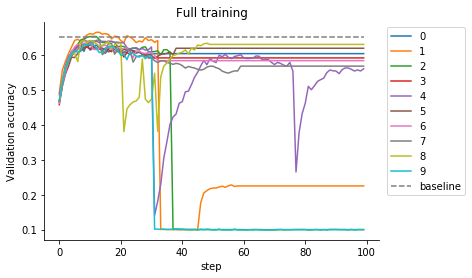

In [22]:
plot_all_logs(full_training_epoch_logs, 'Validation accuracy', baseline=baseline)
plt.title('Full training')

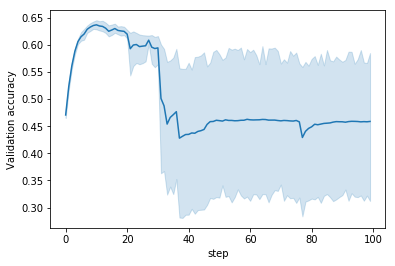

In [25]:
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(full_training_epoch_logs))

Note that, while all models achieved an adequate validation accuracy quickly enough, a couple of models collapsed as the value of **alpha diminished**.

### b) Pretrained hider

Here the **hider** part of the network was pretrained, in an unsupervised fashion, as an autoencoder.

Text(0.5, 1.0, 'Pretrained hider')

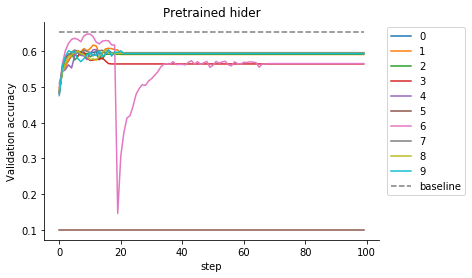

In [5]:
experiment_dir = '../logs/cifar10/hns/deterministic/pretrained_hider_10/'
pretrained_hider_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
plot_all_logs(pretrained_hider_epoch_logs, 'Validation accuracy', baseline=baseline)
plt.title('Pretrained hider')

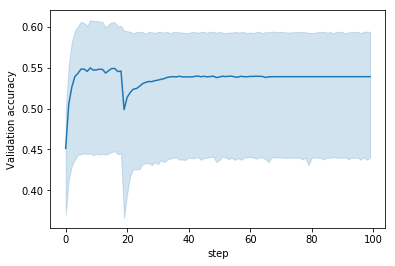

In [27]:
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(pretrained_hider_epoch_logs))

A model, again, collapsed, while two models settled for sub-optimal validation accuracies.

### c) Pretrained seeker

The **seeker** part was pretrained for classification in these experiments.

Text(0.5, 1.0, 'Pretrained seeker')

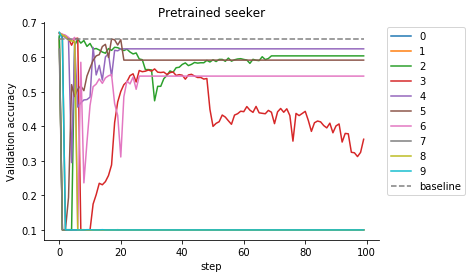

In [6]:
experiment_dir = '../logs/cifar10/hns/deterministic/pretrained_seeker_10/'
pretrained_seeker_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
plot_all_logs(pretrained_seeker_epoch_logs, 'Validation accuracy', baseline=baseline)
plt.title('Pretrained seeker')

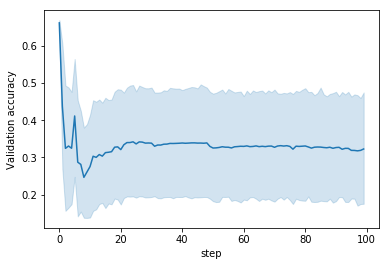

In [28]:
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(pretrained_seeker_epoch_logs))

These experiments tured out quite unstable and led to a lot of collapses and sub-par performances. 

### d) Both hider and seeker pretrained

This involved pretraining **both** the hider and seeker models, independently, with the methods mentioned above.

Text(0.5, 1.0, 'Pretrained hider and seeker')

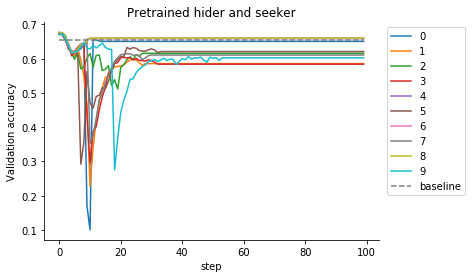

In [7]:
experiment_dir = '../logs/cifar10/hns/deterministic/pretrained_both_10/'
pretrained_both_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
plot_all_logs(pretrained_both_epoch_logs, 'Validation accuracy', baseline=baseline)
plt.title('Pretrained hider and seeker')

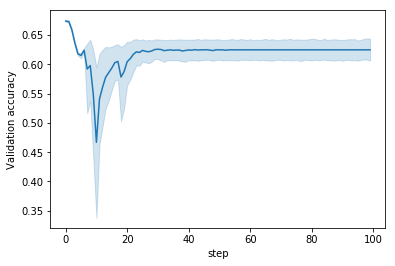

In [29]:
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(pretrained_both_epoch_logs))

Regarding the classification of the models, these experiments proved to be the best both in terms of performance, stability and reliability. None of the 10 models collapsed during training.

## 2. Batch logs

The reason for the collapse of some models above is that they settled for the sub-optimal solution of hiding all the pixels in the image, which leads to low mask loss and consequently a low total loss in the final stages of training. To filter out these solutions, we'll consider only models that achieve an accuracy more than 90% of the baseline ($\approx 59\%$ validaition accuracy).

An additional option is available for undersampling the logs, if they take too long to plot (see `utils.plotting.load_and_process_batch_logs_from_dir`).

### a) Full training

In [8]:
experiment_dir = '../logs/cifar10/hns/deterministic/full_training_10/'
full_training_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir, resample_one_every=None)
full_training_batch_logs = filter_logs_on_val_acc(full_training_epoch_logs, full_training_batch_logs, baseline)

Text(0.5, 1.0, 'Full training')

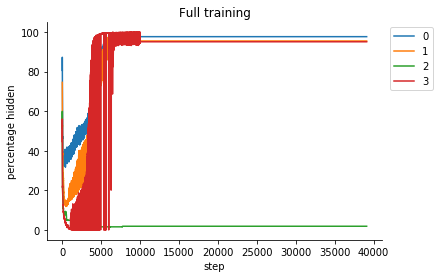

In [9]:
plot_all_logs(full_training_batch_logs, 'percentage hidden')
plt.title('Full training')

Out of the 10 models, only 4 managed to surpass the validation accuracy threshold. Out of these 4, 3 managed to do so by hiding a large part of the input image. However, they featured heavy oscillations on their transitions.

### b) Pretrained hider

In [10]:
experiment_dir = '../logs/cifar10/hns/deterministic/pretrained_hider_10/'
pretrained_hider_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir, resample_one_every=None)
pretrained_hider_batch_logs = filter_logs_on_val_acc(pretrained_hider_epoch_logs, pretrained_hider_batch_logs, baseline)

Text(0.5, 1.0, 'Pretrained hider')

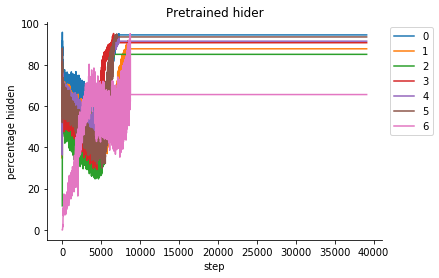

In [11]:
plot_all_logs(pretrained_hider_batch_logs, 'percentage hidden')
plt.title('Pretrained hider')

These models performed a bit better that the previous. First of all, 7 models achieved a high enough validation accuracy, while most settled for solutions that hide a large number of pixels. Interestingly, while when performing a complete training, the models settled to extreme solutions (i.e. either hiding 95% or hiding 0% of the images), here the models show a higher stability and tend to settle for sub-optimal solutions instead of comlpetely collapsing.

In [12]:
experiment_dir = '../logs/cifar10/hns/deterministic/pretrained_seeker_10/'
pretrained_seeker_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir, resample_one_every=None)
pretrained_seeker_batch_logs = filter_logs_on_val_acc(pretrained_seeker_epoch_logs, pretrained_seeker_batch_logs, baseline)

Text(0.5, 1.0, 'Pretrained seeker')

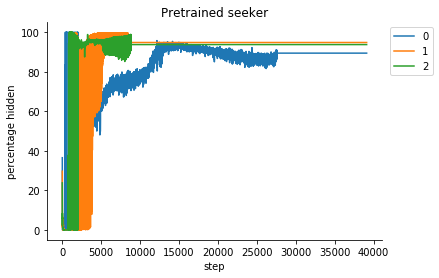

In [13]:
plot_all_logs(pretrained_seeker_batch_logs, 'percentage hidden')
plt.title('Pretrained seeker')

Just three models passed the validation accuracy threshold, all three of which managed to do so while hiding a large number of input pixels. Two in-fact settled for near-optimal solutions.

In [14]:
experiment_dir = '../logs/cifar10/hns/deterministic/pretrained_both_10/'
pretrained_both_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir, resample_one_every=None)
pretrained_both_batch_logs = filter_logs_on_val_acc(pretrained_both_epoch_logs, pretrained_both_batch_logs, baseline)

Text(0.5, 1.0, 'Pretrained both hider and seeker')

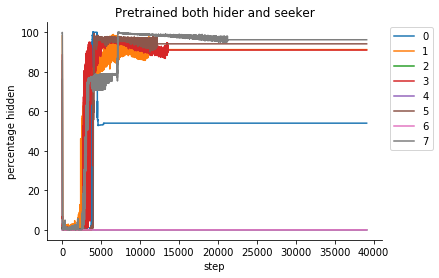

In [15]:
plot_all_logs(pretrained_both_batch_logs, 'percentage hidden')
plt.title('Pretrained both hider and seeker')

Most of the models here settled for good enough solutions, while a few experienced collapses and sub-optimal solutions.

## 3. Comparison

Firstly, let's compare just the accuracy of the models.

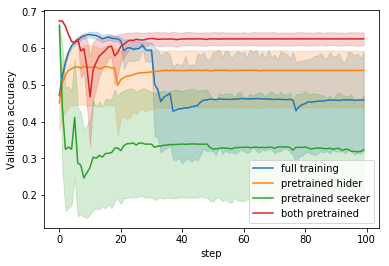

In [30]:
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(full_training_epoch_logs), label='full training')
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(pretrained_hider_epoch_logs), label='pretrained hider')
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(pretrained_seeker_epoch_logs), label='pretrained seeker')
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(pretrained_both_epoch_logs), label='both pretrained')

plt.legend()

This shows that the two models with the pretrained hider components, are more stable than the other two (i.e. less collapses which lead to a higher mean accuracy).

The next thing we'll do is set a threshold of 90% pixels hidden to filter out sub-optimal solutions. Then we'll see how  many models of each category managed to surpass these two thresholds (i.e. the validation accuracy one and the pixels hidden one).

In [16]:
full_training_batch_logs = filter_logs_on_pix_hidden(full_training_batch_logs)
pretrained_hider_batch_logs = filter_logs_on_pix_hidden(pretrained_hider_batch_logs)
pretrained_seeker_batch_logs = filter_logs_on_pix_hidden(pretrained_seeker_batch_logs)
pretrained_both_batch_logs = filter_logs_on_pix_hidden(pretrained_both_batch_logs)

print('Full training:     ', len(full_training_batch_logs))
print('Pretrained hider:  ', len(pretrained_hider_batch_logs))
print('Pretrained seeker: ', len(pretrained_seeker_batch_logs))
print('Pretrained both:   ', len(pretrained_both_batch_logs))

Full training:      3
Pretrained hider:   4
Pretrained seeker:  2
Pretrained both:    4


The convergence seems to be happening by models with a **pretrained hider**. A pretrained seeker **doesn't** seem to help much. There aren't many differences from strategy to strategy, though. 

Let's their best models (these were found empirically: which had the *best looking* curves using `plot_all_curves(xxx_batch_logs, 'percentage hidden')`):

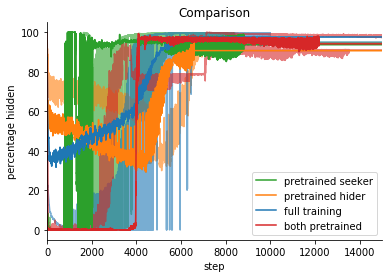

In [17]:
fancy_plot(pretrained_seeker_batch_logs, 'percentage hidden', 1, color='C2', label='pretrained seeker')
fancy_plot(pretrained_hider_batch_logs, 'percentage hidden', 1, color='C1', label='pretrained hider')
fancy_plot(full_training_batch_logs, 'percentage hidden', 0, color='C0', label='full training')
fancy_plot(pretrained_both_batch_logs, 'percentage hidden', 2, color='C3', label='both pretrained')
plt.xlim([0, 15000])
plt.legend(loc='lower right')
plt.title('Masking percentage comparison')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

The models with the pretrained hider appear here, again, more stable.

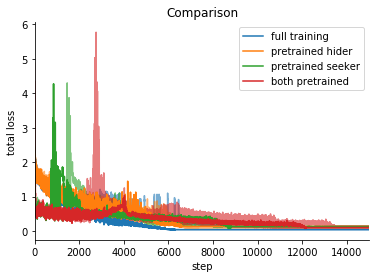

In [18]:
fancy_plot(full_training_batch_logs, 'total loss', 0, color='C0', label='full training')
fancy_plot(pretrained_hider_batch_logs, 'total loss', 1, color='C1', label='pretrained hider')
fancy_plot(pretrained_seeker_batch_logs, 'total loss', 1, color='C2', label='pretrained seeker')
fancy_plot(pretrained_both_batch_logs, 'total loss', 2, color='C3', label='both pretrained')
plt.xlim([0, 15000])
plt.legend(loc='upper right')
plt.title('Total loss comparison')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

The total loss is an interesting metric, because it shows the actual criterion that the models were trained on.

Another interesting thing to view is the **alpha** parameter, which regulates the importance of the classification and mask losses when computing the total loss.

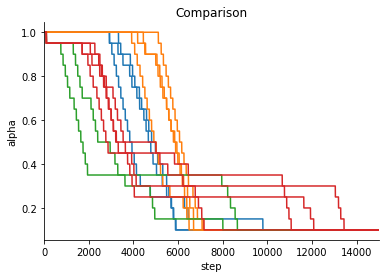

In [19]:
log_type = [full_training_batch_logs, pretrained_hider_batch_logs, 
            pretrained_seeker_batch_logs, pretrained_both_batch_logs]

for i, logs in enumerate(log_type):
    for log in logs:
        plt.plot(log['step'], log['loss regulator'], c='C'+str(i))
        
plt.xlim([0, 15000])
plt.title('Comparison')
plt.ylabel('alpha')
plt.xlabel('step')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

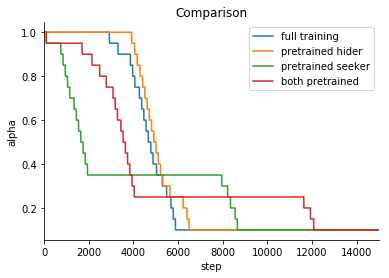

In [20]:
plt.plot(full_training_batch_logs[0]['step'], full_training_batch_logs[0]['loss regulator'], label='full training')
plt.plot(pretrained_hider_batch_logs[1]['step'], pretrained_hider_batch_logs[1]['loss regulator'], label='pretrained hider')
plt.plot(pretrained_seeker_batch_logs[1]['step'], pretrained_seeker_batch_logs[1]['loss regulator'], label='pretrained seeker')
plt.plot(pretrained_both_batch_logs[2]['step'], pretrained_both_batch_logs[2]['loss regulator'], label='both pretrained')

plt.xlim([0, 15000])
plt.title('Comparison')
plt.ylabel('alpha')
plt.xlabel('step')
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

An interesting observation is that all of these models that offer good solutions have converged quick enough (i.e. all within 12000 training iterations).

## 4. Discussion

### Observations

- Around **33%** of the models converge to the desired solutions (i.e. high classification accuracy and high percentage of pixels hidden).
- Pretraining some components of the models **doesn't** seem to affect this percentage significantly.
- Regarding the **classification performance**:
    - Pretraining the **hider** seems to **lower the variance** in accuracy from model to model, but it limits the models to **sub-optimal performance**.
    - Pretraining the **seeker**, **increases the variance** from model to model, but its high-performance models achieve **baseline-level** performance.
    - Pretraining **both** hider and seeker, **reduces the variance**, while maintaining **baseline-level** performance.
- Regarding the **masking performance** of high-performance-in-classification models:
    - **Without a pretrained hider**, we observed a highly polarized performance. Either the models achieved optimal performance or they collapsed.
    - A pretrained hider, allowed for intermediate solutions (e.g. hiding 60-70% of the input image), which wasn't observed on other settings. However this seems to slighly **increase** training times, though this isn't a high price to pay for increased stability.

### Conclusions

- For these reasons, pretraining the hider is **recommended**, as is pretraining both components, if possible.
- However, since even vanilla models converge sufficiently, training the models from scratch is a **viable solution**.
- There is **little reason** to pretrain the seeker on its own.